# **Test Case: Create Money Asistance**

- **Name**: Daffa Albari
- **Email**: daffaa.albari@gmail.com

## Test Case

### Soal
Buatlah sebuah AI assistant untuk membantu analisis keuangan pribadi. Assistant ini akan membantu user menganalisis pengeluaran mereka dan memberikan rekomendasi penghematan.

### Data Source
1. CSV file: transaksi bank (kolom: tanggal, nominal, kategori, keterangan)
2. PDF file: struk-struk belanja yang diupload user
3. SQLite DB: budget categories dan rules (Database bebas)

### Feature
1. Upload dan analisis CSV transaksi bank
2. Upload struk belanja (PDF) dan ekstrak informasinya
3. Kategorisasi otomatis transaksi
4. Visualisasi pengeluaran per kategori
5. Generate monthly report dengan insights
6. Rekomendasi penghematan berdasarkan spending pattern

### Tech Stack:
- Python FastAPI
- LangChain untuk RAG
- SQLite untuk structured data
- Basic LLM Provider (misal: GPT, Gemini, Groq)
- Streamlit untuk visualisasi sederhana


### Example queries yang harus bisa dijawab:
1. "Apa kategori dengan pengeluaran terbesar bulan ini?"
2. "Tolong analisis struk belanja supermarket ini dan bandingkan dengan budget"
3. "Berikan 3 rekomendasi cara menghemat pengeluaran bulan depan"


## **Import Library**

In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.output_parsers import JsonOutputParser
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_vertexai import ChatVertexAI
from langchain_google_vertexai import VertexAIEmbeddings
from langchain.tools import tool
from langchain_chroma import Chroma
from langchain_community.utilities import SQLDatabase
from langchain_community.document_loaders import PyPDFLoader
from langchain import hub
from langchain.utilities import SQLDatabase
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.agents.agent_types import AgentType

from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.tools import Tool, StructuredTool

import vertexai
import os
import pandas as pd
import sqlite3
import datetime

/media/daffaa/Wudapp/Kazee-test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Setup the environment**

In [2]:
_ = load_dotenv()

In [3]:
PROJECT_ID = os.getenv("PROJECT_ID")
LOCATION = os.getenv("LOCATION")

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [4]:
LANGCHAIN_TRACING_V2= os.getenv('LANGCHAIN_TRACING_V2')
LANGCHAIN_ENDPOINT= os.getenv('LANGCHAIN_ENDPOINT')
LANGCHAIN_API_KEY= os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_PROJECT= os.getenv('LANGCHAIN_PROJECT')

In [5]:
llm = ChatGoogleGenerativeAI(model="gemini-pro")
llm.invoke("Say Hi.")

AIMessage(content='Hi there!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b317a5d6-cdbb-4a3a-8ada-145c3eb0072e-0', usage_metadata={'input_tokens': 4, 'output_tokens': 3, 'total_tokens': 7, 'input_token_details': {'cache_read': 0}})

In [6]:
llm = ChatVertexAI(
    model="gemini-1.5-pro-001",
    temperature=0,
)

llm.invoke("Hi.")

AIMessage(content='Hi! 👋  How can I help you today? 😊 \n', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.032470703125, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.03173828125}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.048828125, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.046630859375}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.048095703125, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.0169677734375}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.13671875, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.0240478515625}], 'usage_metadata': {'prompt

## **Initial Setup Dummy Data Source**

### 1. Create SQLite DB

In [56]:
def initialize_db():
    conn = sqlite3.connect("data/finance.db")
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS budget_categories (
        id INTEGER PRIMARY KEY,
        category TEXT,
        rules TEXT,
        budget REAL
    )
    """)
    conn.commit()
    conn.close()

initialize_db()

Category yang akan digunakan (Bank Jago):
Bills
Education
Entertainment
Foods & Drinks
Healthcare
Shopping
Social Events
Topup 
Transportation
Others

In [57]:
def insert_budget_categories():
    categories = [
        ("Bills", "cable tv, credit card, Electricity, Gas, Insurance, Internet, Landline, Maintencance Fee, Mobile & data, rent, Subcription, Water", 1000000),
        ("Education", "tuition, books, courses", 500000),
        ("Entertainment", "movies, concerts, subscriptions, vacation, streaming services, Hangout, Games, Hobby", 300000),
        ("Foods & Drinks", "restaurants, cafes, Take outs", 1500000),
        ("Healthcare", "Drugs/Medicine, Gym/Fitness, Medical fee, Personal care, Sports", 800000),
        ("Shopping", "Fasion, electronics, accessories, Groceries, Gadget", 700000),
        ("Social Events", "weddings, charity & donations, funeral, gifts", 400000),
        ("Topup", "Brizzi BRI, Dana, Flazz BCA, GoPay, LinkAja, Mandiri E-Money, OVO, ShopeePay, TapCash", 200000),
        ("Transportation", "Gasoline, public transport, tolls, Parking fee, Travel fares, Taxi/Ojol, Vehicle maintenance", 500000),
        ("Others", "miscellaneous, undefined expenses", 300000)
    ]

    conn = sqlite3.connect("data/finance.db")
    cursor = conn.cursor()  
    cursor.executemany("""
    INSERT INTO budget_categories (category, rules, budget) VALUES (?, ?, ?)
    """, categories)
    conn.commit()
    conn.close()


insert_budget_categories()

In [58]:
db = SQLDatabase.from_uri("sqlite:///data/finance.db")

print(db.dialect)
print(db.get_usable_table_names())

sqlite
['budget_categories']


In [16]:
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=SQLDatabaseToolkit(db=db, llm=llm),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION
)

In [18]:
agent_executor.invoke(
    "What is the budget for bills?"
)



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: budget_categoriesThought: I should check the schema for the budget_categories table.
Action: sql_db_schema
Action Input: budget_categories
CREATE TABLE budget_categories (
	id INTEGER, 
	category TEXT, 
	rules TEXT, 
	budget REAL, 
	PRIMARY KEY (id)
)

/*
3 rows from budget_categories table:
id	category	rules	budget
1	Bills	cable tv, credit card, Electricity, Gas, Insurance, Internet, Landline, Maintencance Fee, Mobile & d	1000000.0
2	Education	tuition, books, courses	500000.0
3	Entertainment	movies, concerts, subscriptions, vacation, streaming services, Hangout, Games, Hobby	300000.0
*/Thought: I can query the budget_categories table for the budget where the category is Bills.
Action: sql_db_query_checker
Action Input: SELECT budget FROM budget_categories WHERE category = 'Bills' LIMIT 1;```sql
SELECT budget FROM budget_categories WHERE category = 'Bills' LIMIT 1;
```Action: sql_db_query
Action Input

{'input': 'What is the budget for bills?', 'output': '1000000.0'}

In [19]:
# query data
def query_budget_categories():
    conn = sqlite3.connect("data/finance.db")
    df = pd.read_sql_query("SELECT * FROM budget_categories", conn)
    conn.close()
    return df

query_budget_categories()

,id,category,rules,budget
0,1,Bills,"cable tv, credit card, Electricity, Gas, Insur...",1000000.0
1,2,Education,"tuition, books, courses",500000.0
2,3,Entertainment,"movies, concerts, subscriptions, vacation, str...",300000.0
3,4,Foods & Drinks,"restaurants, cafes, Take outs",1500000.0
4,5,Healthcare,"Drugs/Medicine, Gym/Fitness, Medical fee, Pers...",800000.0
5,6,Shopping,"Fasion, electronics, accessories, Groceries, G...",700000.0
6,7,Social Events,"weddings, charity & donations, funeral, gifts",400000.0
7,8,Topup,"Brizzi BRI, Dana, Flazz BCA, GoPay, LinkAja, M...",200000.0
8,9,Transportation,"Gasoline, public transport, tolls, Parking fee...",500000.0
9,10,Others,"miscellaneous, undefined expenses",300000.0


### 2. Create Transaction Data

In [4]:
import random 
from datetime import datetime, timedelta

In [9]:
def generate_bank_transactions(num_transactions=30):  
    # Definisikan kategori dan nominal  
    categories = [  
        ("Bills", "cable tv, credit card, Electricity, Gas, Insurance, Internet, Landline, Maintenance Fee, Mobile & data, rent, Subscription, Water", 1000000),  
        ("Education", "tuition, books, courses", 500000),  
        ("Entertainment", "movies, concerts, subscriptions, vacation, streaming services, Hangout, Games, Hobby", 300000),  
        ("Foods & Drinks", "restaurants, cafes, Take outs", 1500000),  
        ("Healthcare", "Drugs/Medicine, Gym/Fitness, Medical fee, Personal care, Sports", 800000),  
        ("Shopping", "Fashion, electronics, accessories, Groceries, Gadget", 700000),  
        ("Social Events", "weddings, charity & donations, funeral, gifts", 400000),  
        ("Topup", "Brizzi BRI, Dana, Flazz BCA, GoPay, LinkAja, Mandiri E-Money, OVO, ShopeePay, TapCash", 200000),  
        ("Transportation", "Gasoline, public transport, tolls, Parking fee, Travel fares, Taxi/Ojol, Vehicle maintenance", 500000),  
        ("Others", "miscellaneous, undefined expenses", 300000)  
    ]  
  
    # Buat list untuk menyimpan data transaksi  
    data = []  
  
    # Generate data transaksi  
    for i in range(num_transactions):  
        # Pilih kategori secara acak  
        category = random.choice(categories)  
        # Tentukan tanggal transaksi  
        date = datetime.now() - timedelta(days=random.randint(0, 30))  # 30 hari terakhir  
        # Tambahkan data transaksi ke list  
        data.append({  
            "Tanggal": date.strftime("%Y-%m-%d"),  
            "Nominal": category[2],  
            "Kategori": category[0],  
            "Keterangan": category[1].split(',')[0]  # Hanya ambil nama kategori pertama  
        })  
  
    # Buat DataFrame dari data transaksi  
    df_transaksi = pd.DataFrame(data)  
      
    return df_transaksi  
  
# Panggil fungsi untuk menghasilkan data transaksi  
df_transaksi = generate_bank_transactions(30)  


In [8]:
df_transaksi.to_csv("data/transactions.csv", index=False)

In [10]:
df_transaksi.head()

,Tanggal,Nominal,Kategori,Keterangan
0,2024-12-17,800000,Healthcare,Drugs/Medicine
1,2024-12-17,300000,Entertainment,movies
2,2024-12-28,1000000,Bills,cable tv
3,2024-12-19,1500000,Foods & Drinks,restaurants
4,2024-12-29,700000,Shopping,Fashion


## **Processing**

In [216]:
example_text = """
NOTA PEMBELIAN  
========================================================  
Tanggal       : 19 Agustus 2023  
Nomor Nota    : NP2023-0088  
Pemasok       : PT Kopi Makmur  
Alamat        : Jl. Pahlawan No. 45  
Kota          : Bandung  
Telepon       : (022) 9876-5432  
  
--------------------------------------------------------  
No  Nama Kopi          Jumlah (Kg)  Harga Satuan   Total Harga  
1.  Arabika Mandheling 10            Rp80.000       Rp 800.000  
2.  Robusta Lampung    15            Rp65.000       Rp 975.000  
3.  Liberika Aceh      5             Rp90.000       Rp 450.000  
4.  Excelsa Sulawesi   8             Rp75.000       Rp 600.000  
--------------------------------------------------------  
Jumlah Pembelian      : Rp 2.825.000  
Diskon (3%)          : Rp 84.750  
Total Pembayaran     : Rp 2.740.250  
--------------------------------------------------------  
Metode Pembayaran    : Transfer Bank  
--------------------------------------------------------  
Terima kasih atas pembeliannya!  
========================================================  
Catatan: 
"""

In [12]:
import pypdf 

def extract_text_from_pdf(pdf_path):   
    reader = pypdf.PdfReader(pdf_path)  

    extracted_text = ""  

    for page in reader.pages:  
        extracted_text += page.extract_text() + "\n" 
  
    return extracted_text  
  
receipt_path = "data/reciept_1.pdf"  
text = extract_text_from_pdf(receipt_path)  
print(text) 

SUPERMARKET ABC
Jl. Raya No. 123
        
Tanggal: 2024-01-15
Waktu: 14:30
        
Item:
1. Beras 5kg     Rp 65.000
2. Telur 1kg     Rp 28.000
3. Minyak 2L     Rp 45.000
4. Gula 1kg      Rp 15.000
5. Sabun         Rp 12.000
        
Total:          Rp 165.000
       
Terima kasih atas kunjungan Anda!



In [ ]:
def extract_receipt(pdf_path):
    loader = PyPDFLoader(pdf_path)

    docs = loader.load()

    return docs

receipt_path = "data/reciept_1.pdf"
receipt = extract_receipt(receipt_path) 

print(receipt)
    

[Document(metadata={'source': 'data/reciept_1.pdf', 'page': 0}, page_content='SUPERMARKET ABC\nJl. Raya No. 123\n====================\n        \nTanggal: 2024-01-15\nWaktu: 14:30\n        \nItem:\n1. Beras 5kg     Rp 65.000\n2. Telur 1kg     Rp 28.000\n3. Minyak 2L     Rp 45.000\n4. Gula 1kg      Rp 15.000\n5. Sabun         Rp 12.000\n        \nTotal:          Rp 165.000\n       \nTerima kasih atas kunjungan Anda!')]


In [27]:
embeddings = VertexAIEmbeddings(
    model_name='text-multilingual-embedding-002'
)

In [28]:
vector_store = Chroma.from_documents(
    receipt,
    embeddings,
    collection_name="receipts",
    persist_directory='data/'
)

reciept_retriever = vector_store.as_retriever(search_kwargs={"k": 1})

In [29]:
docs = reciept_retriever.invoke('Saya beli apa saja?')

In [30]:
docs

[Document(id='24b7188c-cd1d-4203-9db8-69e79b59e6f1', metadata={'page': 0, 'source': 'data/reciept_1.pdf'}, page_content='SUPERMARKET ABC\nJl. Raya No. 123\n====================\n        \nTanggal: 2024-01-15\nWaktu: 14:30\n        \nItem:\n1. Beras 5kg     Rp 65.000\n2. Telur 1kg     Rp 28.000\n3. Minyak 2L     Rp 45.000\n4. Gula 1kg      Rp 15.000\n5. Sabun         Rp 12.000\n        \nTotal:          Rp 165.000\n       \nTerima kasih atas kunjungan Anda!')]

### Transaction Parser

In [59]:
docs = pd.read_csv("data/transactions.csv")

docs.to_string()

'       Tanggal  Nominal        Kategori     Keterangan\n0   2025-01-11   300000   Entertainment         movies\n1   2025-01-07  1500000  Foods & Drinks    restaurants\n2   2025-01-03   200000           Topup     Brizzi BRI\n3   2025-01-14  1000000           Bills       cable tv\n4   2025-01-11   500000       Education        tuition\n5   2025-01-12   200000           Topup     Brizzi BRI\n6   2024-12-21   300000          Others  miscellaneous\n7   2025-01-10  1000000           Bills       cable tv\n8   2025-01-16   400000               -       weddings\n9   2025-01-08  1000000           Bills       cable tv\n10  2024-12-28  1500000  Foods & Drinks    restaurants\n11  2025-01-01  1500000  Foods & Drinks    restaurants\n12  2024-12-21   500000               -        tuition\n13  2025-01-06   500000  Transportation       Gasoline\n14  2024-12-17   500000  Transportation       Gasoline\n15  2024-12-24  1500000  Foods & Drinks    restaurants\n16  2025-01-07   700000        Shopping        

In [132]:
transaction_data = docs
def query_budget_categories():
    conn = sqlite3.connect("data/finance.db")
    df = pd.read_sql_query("SELECT budget, rules FROM budget_categories", conn)
    conn.close()
    return df

categories_data = query_budget_categories()

In [133]:
print(categories_data)

      budget                                              rules
0  1000000.0  cable tv, credit card, Electricity, Gas, Insur...
1   500000.0                            tuition, books, courses
2   300000.0  movies, concerts, subscriptions, vacation, str...
3  1500000.0                      restaurants, cafes, Take outs
4   800000.0  Drugs/Medicine, Gym/Fitness, Medical fee, Pers...
5   700000.0  Fasion, electronics, accessories, Groceries, G...
6   400000.0      weddings, charity & donations, funeral, gifts
7   200000.0  Brizzi BRI, Dana, Flazz BCA, GoPay, LinkAja, M...
8   500000.0  Gasoline, public transport, tolls, Parking fee...
9   300000.0                  miscellaneous, undefined expenses


In [61]:
template_prompt = """
Your task is to check the transactions have a categories or not. If the transaction dont have a category, you can assign a category to the transaction.
In category have a rules, if the transaction have a keyword in the rules, you can assign the category to the transaction.

here is the list of transactions:
{transaction}

Here is the list of categories:
{categories}

please answer in the following format json. always answer in the following format.
{{
    "date": <date>,
    "category": <category>,
    "amount": <amount>,
    "description": <description>
}}
"""

prompt = ChatPromptTemplate.from_template(template_prompt)
output_parser = JsonOutputParser()

chain = prompt | llm | output_parser

response = chain.invoke({
    "transaction": transaction_data,
    "categories": categories_data
})


print(response)

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ServiceUnavailable: 503 recvmsg:Connection reset by peer.


[{'date': '2025-01-11', 'category': 'Entertainment', 'amount': 300000, 'description': 'movies'}, {'date': '2025-01-07', 'category': 'Foods & Drinks', 'amount': 1500000, 'description': 'restaurants'}, {'date': '2025-01-03', 'category': 'Topup', 'amount': 200000, 'description': 'Brizzi BRI'}, {'date': '2025-01-14', 'category': 'Bills', 'amount': 1000000, 'description': 'cable tv'}, {'date': '2025-01-11', 'category': 'Education', 'amount': 500000, 'description': 'tuition'}, {'date': '2025-01-12', 'category': 'Topup', 'amount': 200000, 'description': 'Brizzi BRI'}, {'date': '2024-12-21', 'category': 'Others', 'amount': 300000, 'description': 'miscellaneous'}, {'date': '2025-01-10', 'category': 'Bills', 'amount': 1000000, 'description': 'cable tv'}, {'date': '2025-01-16', 'category': 'Social Events', 'amount': 400000, 'description': 'weddings'}, {'date': '2025-01-08', 'category': 'Bills', 'amount': 1000000, 'description': 'cable tv'}, {'date': '2024-12-28', 'category': 'Foods & Drinks', 'am

In [24]:
type(response)

list

In [62]:
transaction_clean = pd.DataFrame(response)

transaction_clean

,date,category,amount,description
0,2025-01-11,Entertainment,300000,movies
1,2025-01-07,Foods & Drinks,1500000,restaurants
2,2025-01-03,Topup,200000,Brizzi BRI
3,2025-01-14,Bills,1000000,cable tv
4,2025-01-11,Education,500000,tuition
5,2025-01-12,Topup,200000,Brizzi BRI
6,2024-12-21,Others,300000,miscellaneous
7,2025-01-10,Bills,1000000,cable tv
8,2025-01-16,Social Events,400000,weddings
9,2025-01-08,Bills,1000000,cable tv


In [88]:
# save to database
def initialize_transaction_table():
    conn = sqlite3.connect("data/finance.db")
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS transactions (
        id INTEGER PRIMARY KEY,
        date DATE,
        amount REAL,
        description TEXT,
        category TEXT
    )
    """)
    conn.commit()
    conn.close()

In [89]:
def save_transactions_to_db(transactions_df):
    """
    Save processed transactions to SQLite database
    """
    conn = sqlite3.connect("data/finance.db")
    
    # Convert the 'date' column to datetime and handle invalid dates
    transactions_df['date'] = pd.to_datetime(transactions_df['date'], errors='coerce')
    transactions_df = transactions_df.dropna(subset=['date'])  # Remove rows with invalid dates
    transactions_df['date'] = transactions_df['date'].dt.strftime('%Y-%m-%d')  # Format date for SQLite
    
    # Save to the database
    transactions_df.to_sql('transactions', 
                          conn, 
                          if_exists='append', 
                          index=False)
    
    conn.close()
    return len(transactions_df)


In [90]:
initialize_transaction_table()
save_transactions_to_db(transaction_clean)

30

In [91]:
# cek db
conn = sqlite3.connect("data/finance.db")

# cek ada table apa saja
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('budget_categories',), ('transactions',)]


### Reciept Extractor

## Defining Tools

In [92]:
now = datetime.datetime.now()

print(f'the current date and time is: {now.strftime("%Y-%m-%d %H:%M:%S")}')

the current date and time is: 2025-01-17 04:38:25


In [33]:
def current_datetime_tool(query: str) -> str:
    """Return the current date and time based on location"""
    now = datetime.datetime.now()
    return f"The current date and time is: {now.strftime('%Y-%m-%d %H:%M:%S')}"    

In [110]:
from pandasai import SmartDataframe
from pandasai.llm import GoogleVertexAI

df = SmartDataframe('data/transactions.csv', config={'llm': llm})

,Tanggal,Nominal,Kategori,Keterangan
1,2025-01-07,1500000,Foods & Drinks,restaurants
10,2024-12-28,1500000,Foods & Drinks,restaurants
11,2025-01-01,1500000,Foods & Drinks,restaurants
15,2024-12-24,1500000,Foods & Drinks,restaurants


'/media/daffaa/Wudapp/Kazee-test/exports/charts/temp_chart.png'

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/daffaa/snap/code/common/.cache/gio-modules/libgiolibproxy.so
eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


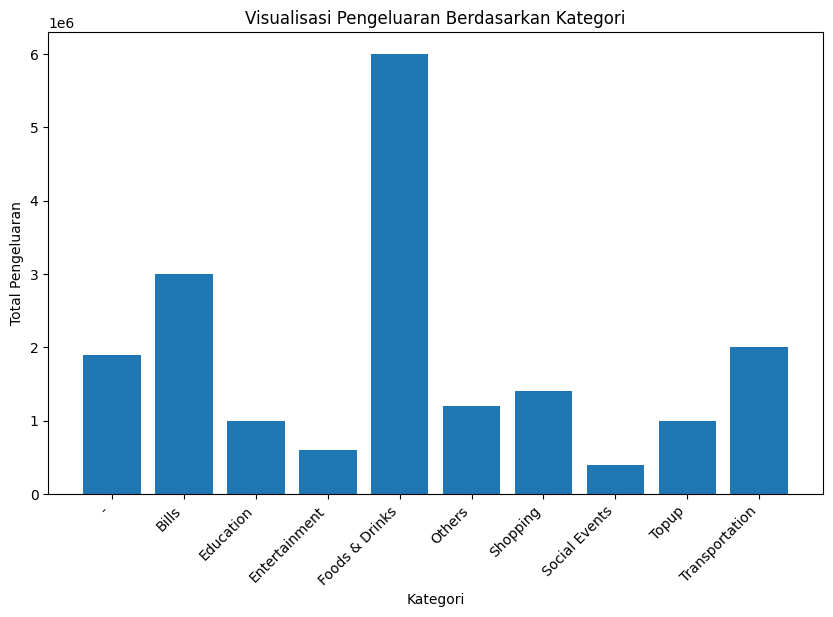

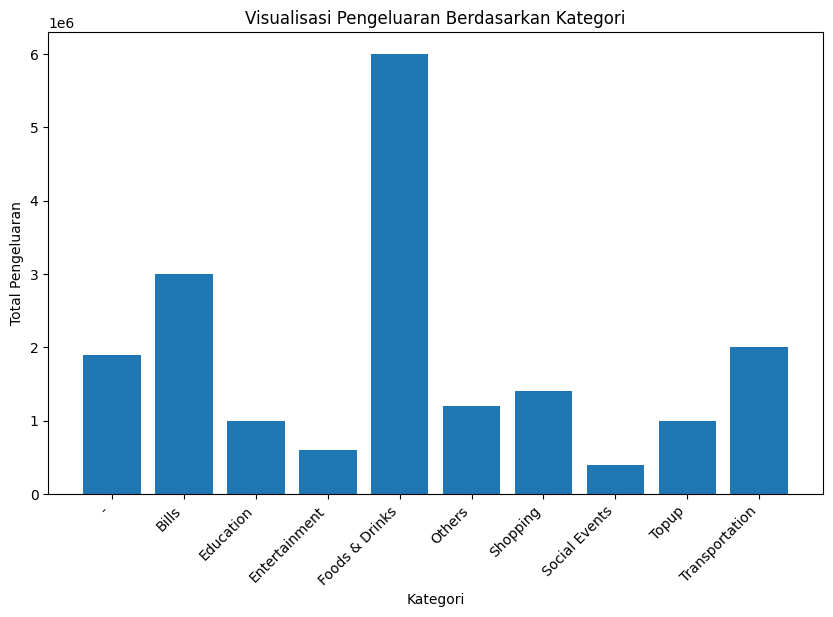

In [113]:
df.chat('Visualisasi pengeluaran berdasarkan kagegori')

### 1. Data Visualisasi Tools

In [61]:
def get_data_transaction():
    """Get the user transaction data"""
    conn = sqlite3.connect("data/finance.db")
    df = pd.read_sql_query("SELECT * FROM transactions", conn)
    conn.close()
    transaction_data = df.to_string()
    
    return transaction_data

In [99]:
from pandasai.connectors import SqliteConnector
from pandasai import SmartDataframe

def visualization_tools(query: str) :
    """Generate visualization from transaction data. This will return a image of the visualization. the path is saved in exports/charts/temp_chart.png"""
    connector = SqliteConnector(
        config={
            'database': 'data/finance.db',
            'table': 'transactions'
        }
    )

    df = SmartDataframe(connector, config={'llm': llm})

    response = df.chat(f"{query}")

    return response 

'/media/daffaa/Wudapp/Kazee-test/exports/charts/temp_chart.png'

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/daffaa/snap/code/common/.cache/gio-modules/libgiolibproxy.so
eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


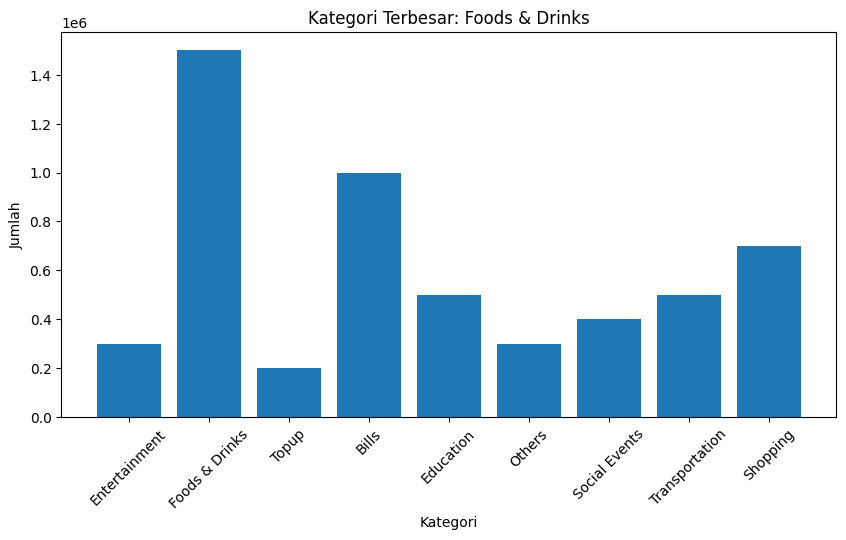

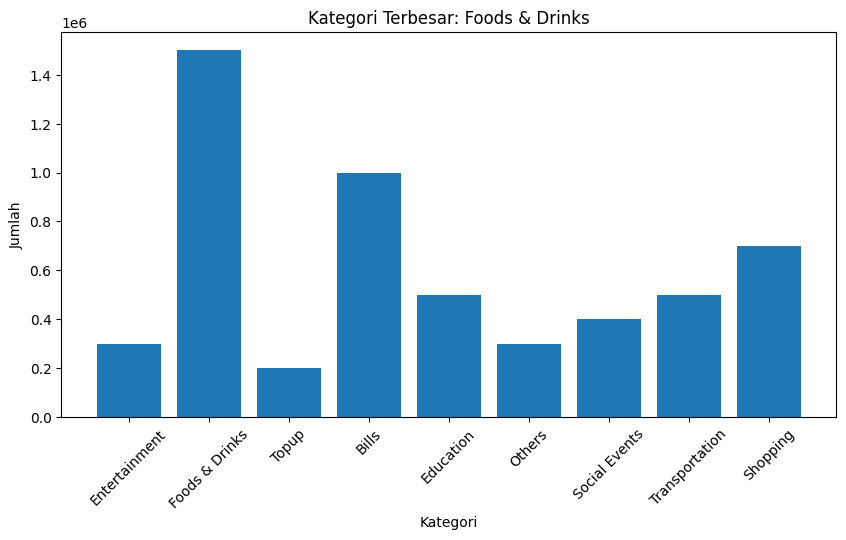

In [117]:
visualization_tools('Buatkan visualisasi dengan kategori terbesar pada data tersebut')

### 2. Monthly Report Generator

In [100]:
def monthly_report(transaction_data: str, user_interaction: str) -> str: 
    """Generate monthly report from the transactions data. To run this function, you need run  """
    messages = [
        (
            "system",
            "You are a helpfull assistant that can help to generate monthly report from the transactions data"
        ),
        ('human', f'Transaction Data: {transaction_data}\n User Instruction: {user_interaction}'),
    ]

    response = llm.invoke(messages)
    return response.content

### 3. Rekomendasi Penghematan

In [101]:
def recomendation_savings(transaction_data: str, user_interaction: str) -> str:
    """Generate recommendation savings from the transaction data or struk belanja"""
    messages = [
        (
            "system",
            "You are a helpfull assistant that can help to generate recommendation savings from the transaction data or struk belanja"
        ),
        ('human', f'Transaction Data: {transaction_data}\nUser Instruction: {user_interaction}'),
    ]

    response = llm.invoke(messages)
    return response.content

In [102]:
from langchain.tools import StructuredTool

In [103]:
# from pydantic import BaseModel, Field

# class RecomentationSavingsInput(BaseModel):
#     transaction_data: str = Field(description='Transaction Data')
#     struk_belanja: str = Field(description='Struk Belanja or Shopping List')
#     user_interaction: str = Field(description='User instruction to the assistant')

In [124]:
tool_strukbelanja_information = create_retriever_tool(
    retriever=reciept_retriever,
    name='StrukBelanjaRetriever',
    description='get information about the shopping receipt/struk belanja with user instruction/input'
)

tool_transaction_data = Tool(
    name='TransactionData',
    func=get_data_transaction,
    description='Get the user transaction data'
)

tool_monthly_report = Tool(
    name='MonthlyReport',
    func=monthly_report,
    description='Generate monthly report from the transactions data'
)

tool_recomendation_savings = Tool(
    name='RecommendationSavings',
    description='Generate recommendation savings from the transaction data or struk belanja based on user interaction',
    func=recomendation_savings,
)

tool_date_time = Tool(
    name='CurrentDateTime',
    func=current_datetime_tool,
    description='Return the current date and time'
)

tool_visualization = Tool(
    name='VisualizationTool',
    func=visualization_tools,
    description='Generate visualization from transaction data'
)


In [125]:
tools = [
    tool_strukbelanja_information,
    tool_date_time,
    tool_transaction_data,
    tool_monthly_report,
    tool_recomendation_savings,
    tool_visualization
]

## Create Agent

In [126]:
main_prompt = """You are a financial assistant that answer about financial questions. You can use the following tools:
CurrentDateTime, StrukBelanjaRetriever, TransactionData, MonthlyReport, RecommendationSavings and VisualizationTool

To use MontlyReport and RecommendationSavings tools, you have to USE TransactionData or StrukBelanjaRetriever tools first.

If the user ask about saving recommendation, you have to use TransactionData and StrukBelanjaRetriever tools to get the data and generate the recommendation.
If the user ask about monthly report, you have to use TransactionData tool and then use MonthlyReport tool to generate comphrensive montly report.


Please use the following format to answer:
If the answer is about visualization, answer with this following format.
{{
    "type": "Visualization",
    "url_img": 'exports/charts/temp.chart.png"
}}

Except  visualization, answer with this following format.
{{
    "type": "chatbot",
    "response": <response>
}}

"""

In [127]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", main_prompt),
        MessagesPlaceholder('chat_history', optional=True),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad")
    ]
)

In [128]:
from langchain.agents import create_tool_calling_agent, AgentExecutor, create_react_agent

agent = create_tool_calling_agent(
    llm, tools=tools, prompt=prompt
)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)



> Entering new AgentExecutor chain...

Invoking: `VisualizationTool` with `Visualisasi pengeluaran terbesar berdasarkan kategori pada transaksi saya`


/media/daffaa/Wudapp/Kazee-test/exports/charts/temp_chart.png

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/daffaa/snap/code/common/.cache/gio-modules/libgiolibproxy.so
eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


{
    "type": "Visualization",
    "url_img": '/media/daffaa/Wudapp/Kazee-test/exports/charts/temp_chart.png'
}


> Finished chain.


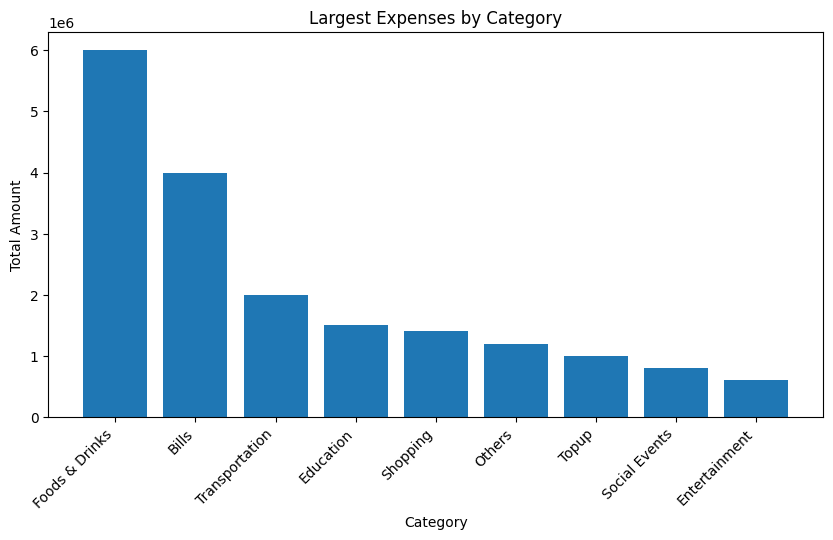

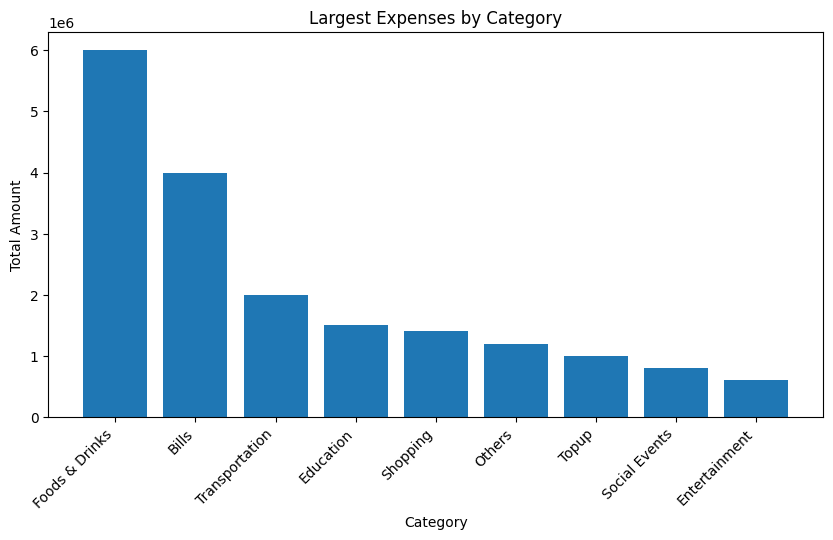

In [130]:
response = agent_executor.invoke({
    'input': 'buakan visualisasi pengeluaran terbesar berdasarkan kategori pada transaksi saya',
})

In [115]:
display(response['output'])

'{\n    "response": "Berikut visualisasi kategori tagihan pada transaksi anda"\n}\n'

## **Notebooks**

In [197]:
from typing import Literal
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [147]:
@tool 
def current_datetime_tool(query: str) -> str:
    """Return the current date and time"""
    now = datetime.datetime.now()
    return f"The current date and time is: {now.strftime('%Y-%m-%d %H:%M:%S')}"    

In [167]:
@tool
def get_data_transaction(query: str):
    """Get the user transaction data"""
    conn = sqlite3.connect("data/finance.db")
    df = pd.read_sql_query("SELECT * FROM transactions", conn)
    conn.close()
    transaction_data = df.to_string()
    
    return transaction_data

In [188]:
@tool
def recommendation_savings(query: str, transaction_data: str):
    """Generate recommendation savings from the transaction data. using get_data_transaction tools to get transaction data"""
    messages = [
        (
            "system",
            "You are a helpfull assistant that can help to generate recommendation savings from the transaction data"
        ),
        ('human', f'Transaction Data: {transaction_data}\n User Instruction: {query}'),
    ]

    response = llm.invoke(messages)
    return response.content

In [189]:
tools = [current_datetime_tool, get_data_transaction, recommendation_savings]

In [190]:
tool_node = ToolNode(tools)

In [191]:
model_with_tools = ChatVertexAI(
    model='gemini-1.5-pro-001', temperature=0
).bind_tools(tools)

In [192]:
def should_continue(state: MessagesState):
    message = state['messages']
    last_message = message[-1]
    if last_message.tool_calls:
        return 'tools'
    return END


# def check_query(state: MessagesState):
#     message = state['messages']


def call_model(state: MessagesState):
    message = state['messages']
    response = model_with_tools.invoke(message)
    return {'messages': response}

In [198]:
memory = MemorySaver()

In [193]:
workflow = StateGraph(MessagesState)

workflow.add_node('agent', call_model)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'agent')
workflow.add_conditional_edges('agent', should_continue, ['tools', END])
workflow.add_edge('tools', 'agent')

In [199]:
app = workflow.compile(checkpointer=memory)

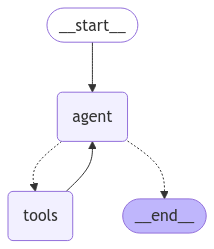

In [200]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [202]:
config = {
    'configurable': {'thread_id': 1}
}

In [203]:
for chunk in app.stream(
    {"messages": [("human", "Berikan saya rekomendasi penghematan berdasarkan data transaksi saya")]}, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Berikan saya rekomendasi penghematan berdasarkan data transaksi saya
================================== Ai Message ==================================
Tool Calls:
  recommendation_savings (f94cbca2-2e22-47f7-aa5a-0ec3c157ef22)
 Call ID: f94cbca2-2e22-47f7-aa5a-0ec3c157ef22
  Args:
    query: Berikan saya rekomendasi penghematan
    transaction_data: unknown
================================= Tool Message =================================
Name: recommendation_savings

Saya ingin membantu Anda memberikan rekomendasi penghematan, tetapi saya memerlukan informasi lebih lanjut. Tolong berikan saya data transaksi Anda. 

Data transaksi dapat berupa:

* **Daftar pengeluaran bulanan:**  Ini bisa berupa tangkapan layar dari aplikasi perbankan Anda, file CSV dari rekening bank Anda, atau bahkan daftar yang Anda buat sendiri. Pastikan untuk menyertakan tanggal, jumlah, dan kategori untuk setiap transaksi (misalnya, ma

In [206]:
from typing import Dict, TypedDict

In [207]:
llm = ChatVertexAI(
    model='gemini-1.5-flash',
    temperature=0.5,
    verbose=True
)

llm.invoke('hai')

AIMessage(content='Hi! 👋  How can I help you today? 😊 \n', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.03564453125, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.03955078125}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.057373046875, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.051025390625}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.0517578125, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.023681640625}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.1357421875, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.0240478515625}], 'usage_metadata': {'promp

In [208]:
class State(TypedDict):
    query: str
    category: str
    response: str

In [209]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, trim_messages

def trim_messages(prompt):
    """Trims conversation histroy to retain only the latest message within the limit"""
    max_messages = 10
    return trim_messages(
        prompt,
        max_tokens=max_messages,
        strategy="last",
        token_counter=len,
        start_on="human", 
        include_system=True,
        allow_partial=False, 
    )

In [210]:

def save_file(data, filename):
    """Saves data to a markdown file with a timestamped filename."""
    folder_name = "Agent_output"  # Folder to store output files
    os.makedirs(folder_name, exist_ok=True)  # Creates the folder if it doesn't exist
    
    # Generate a timestamped filename for uniqueness
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")  # Format: YYYYMMDDHHMMSS
    filename = f"{filename}_{timestamp}.md"
    
    # Define the full file path
    file_path = os.path.join(folder_name, filename)
    
    # Save the data to the file in the specified path
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(data)
        print(f"File '{file_path}' created successfully.")
    
    # Return the full path of the saved file
    return file_path

In [ ]:
from pandasai.connectors import SqliteConnector
from pandasai import SmartDataframe

def visualization_tools(query: str) :
    """Generate visualization from transaction data. This will return a image of the visualization. the path is saved in exports/charts/temp_chart.png"""
    connector = SqliteConnector(
        config={
            'database': 'data/finance.db',
            'table': 'transactions'
        }
    )

    df = SmartDataframe(connector, config={'llm': llm})

    response = df.chat(f"{query}")

    return response 

In [229]:
from pandasai import SmartDataframe
from pandasai.connectors import SqliteConnector
import os

class Visualization:
    def __init__(self, prompt):
        self.model = ChatVertexAI(model='gemini-1.5-pro')
        self.prompt = prompt

    def visualization_agent(self, query):
        connector = SqliteConnector(
            config={
                'database': 'data/finance.db',
                'table': 'transactions'
            }
        )

        data = SmartDataframe(connector, config={'llm': self.model})

        response = data.chat(f"{query}")

        return response

In [230]:
class ShoppingListReader:
    def __init__(self, prompt, tools):
        self.model = ChatVertexAI(model='gemini-1.5-pro')
        self.embedding_model = VertexAIEmbeddings(model_name='text-multilingual-embedding-002')
        self.prompt = prompt
        self.path = 'data/reciept_1.pdf'
        self.tools = [self.rag()]
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)


    def rag(self):
        loader = PyPDFLoader(self.path)
        docs = loader.load()

        vector_store = Chroma.from_documents(
            docs,
            self.embedding_model,
        )

        reciept_retriever = vector_store.as_retriever()

        retrieval_tool = create_retriever_tool(
            retriever=reciept_retriever,
            name='ShoppingListRetriever',
            description='Get information about the shopping list(Struk Belanja)'
        )

        return retrieval_tool  
    
    def generate_response(self, query):
        """Generate a QnA answering agent based on Shopping List"""
        # system_messages = """You are a financial Asisstant that help user to answer their question about their shopping list."""
        # prompt = ChatPromptTemplate.from_messages([
        #     ('system', system_messages),
        #     ('human', "{input}"),
        #     ('placeholder', "{agent_scratchpad}")
        # ])

        response = self.agent_executor.invoke({
            'input': query
        })

        return response
        

In [231]:
def categories(state: State) -> State:
    """Categories the user query into one of three categories: Visualization, Shopping List Reader, Report Maker, Saving Recommendation"""
    template = """
    Categories the following user query into one of these categories:
    1: Visualization
    2: Shopping List Reader
    3: Report Maker
    4: Saving Recommendation

    Give the number only as an output.

    Example: 
    1. Query: "Give me visualization about my transaction" -> 1
    2. Query: "Please, analysis the shopping list" -> 2
    3. Query: "Buatkan laporan pengeluaran bulan kemarin" -> 3
    4. Query: "Apa rekomendasi penghematan saya berdasarkan spendding pattern transaksi saya sebelumnya" -> 4

    Now, Categories the following user query: 
    Query: {query}
    """

    prompt = ChatPromptTemplate.from_template(template)

    chain = prompt | llm

    print('Categorizing the user query.....')
    category = chain.invoke({
        'query': state['query']
    }).content
    return {
        'category': category
    }

In [232]:
def handle_visualization(state: State) -> State:
    """Generate a visualization response based on user query"""
    prompt = ChatPromptTemplate.from_messages([
        ('system', 'You are '),
        ('human', '{input}'),
        ('placeholder', '{agent_scratchpad}')
    ])

    visualization = Visualization(prompt)
    response = visualization.visualization_agent(state['query'])
    return {
        'response': response
    }

In [ ]:
def route_query(state: State):
    """Route the query based on its category to the appriate handler"""
    if '1' in state['category']:
        print('Category: handle_visualization')
        return 'handle_visualization'
    if '2' in state['category']:
        print('Category: handler_shoppinglist')
        return 'handle_shoppinglis'
    if '3' in state['category']:
        print('Category: ')